<h1>MNIST convnet demo</h1>
In this notebook, we try to fit a subset of MNIST using a convolutional network.
We also make use of the "Model" and "Solver" wrapper objects provided by ntb.

In [1]:
from ntb.datasets import mnist
import ntb
import matplotlib.pyplot as pp
import numpy as np
%matplotlib inline
%reload_ext autoreload

In [2]:
#the loader returns a data dict and a visualization routine

data,vis = mnist.load(mode="2d",num_train=6000,num_val=1000)

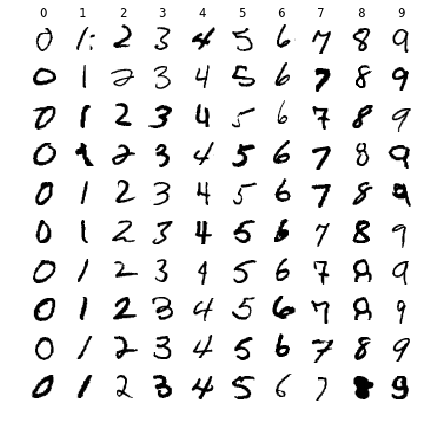

In [3]:
vis()

In [7]:
#we construct a computational graph for a convnet
graph = ntb.ComputationGraph()

with ntb.default_graph(graph):
    #first we define a few placeholder nodes to assign values to during training and prediction
    x = ntb.Placeholder(shape=[-1,1,28,28])
    y = ntb.Placeholder(shape=[-1])
    p = ntb.Placeholder()
    lr = ntb.Placeholder()
    #placeholder to control batch normalization mode
    train = ntb.Placeholder()

    #the auxiliary "layer" functions from ntb.layers always return a result node as well as 
    #learnable parameters equipped with suitable initializers
    #(we could have also constructed the resulting Conv2d nodes manually)

    #convolution with 24 1x5x5 filters followed by subsampling,
    #batch normalization, relu, dropout
    h1,cw1,cb1 = ntb.conv_layer(x,24,5,5,stride=2,padding='minimal') 
    s1 = ntb.max_pool_layer(h1,2,2)
    b1,bn1_g,bn1_b = ntb.spatial_batchnorm_layer(s1,train)
    r1 = ntb.Relu(b1)
    do1 = ntb.Dropout(r1,p)

    #convolution with 14 24x4x4 filters followed by subsampling, batch normalization,
    #relu, dropout and a fully connected layer (relu output)
    h2,cw2,cb2 = ntb.conv_layer(do1,14,4,4,stride=1,padding='minimal')
    b2,bn2_g,bn2_b = ntb.spatial_batchnorm_layer(h2,train)
    r2 = ntb.Relu(b2)
    do2 = ntb.Dropout(r2,p)
    a1,_,_ = ntb.affine_layer(do2,32)
    r3 = ntb.Relu(a1)
    
    #finally we add an affine transformation and cross entropy loss
    scores,w_scores,b_scores = ntb.affine_layer(r3,10)
    pred = ntb.Argmax(scores,axis=1)
    acc = ntb.ClassAccuracy(pred,y)
    loss = ntb.CrossEntropyLogits(scores,y)

    #optimization node, minimizes loss
    optim = ntb.Optim(loss,lr=lr,update_rule='adam')

In [8]:
"""
this time we set up a few subroutines (training step, 
end of epoch report and prediction) which will be used 
for the model. the return values for epoch_step should be 
(name,value) pairs of data to be logged by the solver
"""

def train_step(Xtr,ytr,learning_rate,keep_prob,batchnorm=True):
    loss_tr,_=graph.run([loss,optim],{x:Xtr,y:ytr,
                                      p:keep_prob,
                                      train:batchnorm,
                                      lr:learning_rate})
    return ('batch loss',loss_tr),

def epoch_step(Xtr,ytr,Xval,yval):
    loss_tr,acc_tr=graph.run([loss,acc],{x:Xtr,y:ytr,
                                         p:1.,train:False})
    loss_val,acc_val=graph.run([loss,acc],{x:Xval,y:yval,
                                           p:1.,train:False})
    return ('train loss',loss_tr),('train acc',acc_tr),('val loss',loss_val),('val acc',acc_val)

def predict(X):
    return graph.run([pred],{x:X,p:1.,train:False})[0]

#we wrap our functions in a model object

model = ntb.Model(train_step,epoch_step,predict,graph.reset,graph.save,graph.load)

#then feed it into a solver, specifying 'val acc' as the performance metric

solver = ntb.Solver(data=data,model=model,metric='val acc')

In [10]:
#train for 10 epochs
#the best-performing model (evaluated once at the end of each epoch) is saved
#and restored at the end of training

solver.train(num_epochs=10,learning_rate=1e-2,keep_prob=.79,batchnorm=True)

(Iteration 0/600) batch loss:2.6461
(New best) val acc: 0.258
(Epoch 0/10) train loss:4.8047, train acc:0.262, val loss:5.0587, val acc:0.258
(Iteration 10/600) batch loss:0.9203
(Iteration 20/600) batch loss:0.4419
(Iteration 30/600) batch loss:0.4511
(Iteration 40/600) batch loss:0.1874
(Iteration 50/600) batch loss:0.3907
(Iteration 60/600) batch loss:0.1379
(New best) val acc: 0.942
(Epoch 1/10) train loss:0.1789, train acc:0.947, val loss:0.1641, val acc:0.942
(Iteration 70/600) batch loss:0.1844
(Iteration 80/600) batch loss:0.2536
(Iteration 90/600) batch loss:0.2378
(Iteration 100/600) batch loss:0.1982
(Iteration 110/600) batch loss:0.1885
(Iteration 120/600) batch loss:0.1566
(New best) val acc: 0.954
(Epoch 2/10) train loss:0.1541, train acc:0.948, val loss:0.1332, val acc:0.954
(Iteration 130/600) batch loss:0.1466
(Iteration 140/600) batch loss:0.1522
(Iteration 150/600) batch loss:0.0672
(Iteration 160/600) batch loss:0.1541
(Iteration 170/600) batch loss:0.1322
(Iteratio

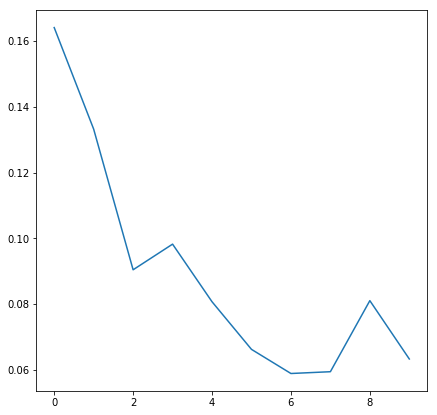

In [11]:
#we can now plot the data we recorded, for instance validation loss (leaving out the 0th epoch)

pp.plot(solver.history['val loss'][1:])

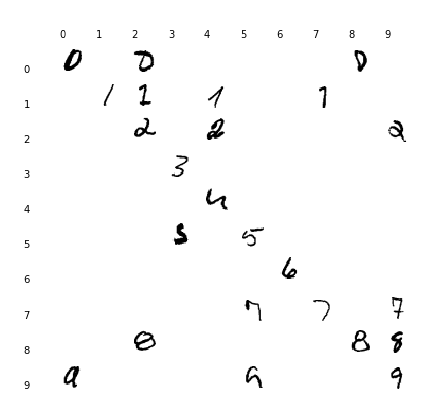

In [15]:
#now we visualize a sample of what the convnet got wrong (and right)
#the column headings are the predicted classes, the row headings are the true classes

ntb.datasets.vis.render_confusion_sample(data,model=model,cmap='gray_r',figsize=(7.0,7.0))

In [16]:
#we see that only a few of them are the sorts of mistakes a human might make

In [13]:
import pickle

#uncomment and run this to save the model
#with open('mnist_model.pickle','wb') as f:
#    pickle.dump(graph.save(),f)

#uncomment and run this to load the saved model
#with open('mnist_model.pickle','wb') as f:
#    graph.load(pickle.load(f))

In [17]:
#furthermore let's have a look at the filters learned by the convnet

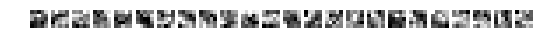

In [18]:
ntb.vis.render_cnn_filters(cw1.value)

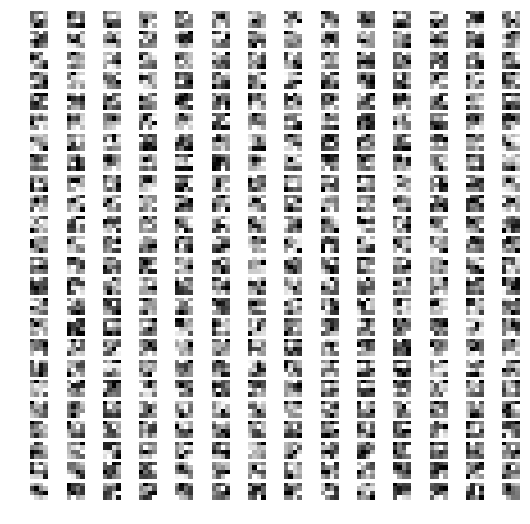

In [19]:
ntb.vis.render_cnn_filters(cw2.value)